It can be proved that as the number of updates goes to infinity, the final configuration generated by the method will be distributed as $p(\sigma|T)$. However, the main step in the proof would be to verify the detailed balance property, which concerns the probability that an update generates configuration $\sigma$ at time $t + 1$, given that the configuration at time $t$ was $\sigma'$. If this probability is $\Pr(\sigma' \to \sigma)$, then the required
condition is that for all pairs $\sigma$, $\sigma'$ then
\begin{equation}
    p(\sigma'|T)\Pr(\sigma' \to \sigma) = p(\sigma|T)\Pr(\sigma \to \sigma'),
\end{equation}
Roughly speaking, this says that if the configurations are already distributed as $p(\sigma|T)$, then the probability to go from $\sigma'$ to $\sigma$ is equal to the probability of making the opposite transition from $\sigma$ to $\sigma'$.

Let $\sigma'$ be the configuration at time $t$, and $\sigma$ be the configuration at time $t+1$. The algorithm updates a single spin $i$.
*   If $\sigma$ and $\sigma'$ differ by more than one spin, then the transition probability is $0$, and the equation holds.
*   If $\sigma = \sigma'$, then the equation holds trivially.

Consider the non-trivial case where the two configurations differ only at spin $i$. Let $\sigma'_i$ be the spin value in the old configuration and $\sigma_i$ be the spin value in the new configuration, such that $\sigma_i = -\sigma'_i$.

The probability of a configuration is given by the Boltzmann distribution
\begin{equation}
    p(\sigma|T) = \frac{1}{Z} e^{-E(\sigma)/T}.
\end{equation}
The ratio is
\begin{equation}
    \frac{p(\sigma|T)}{p(\sigma'|T)} = \frac{e^{-E(\sigma)/T}}{e^{-E(\sigma')/T}} = e^{-\Delta E / T},
\end{equation}
where $\Delta E$ is the difference in energy. The total energy is $E = -\sum \kappa_j \sigma_j$. Since only the spin $i$ changes, we only care about terms involving $\sigma_i$.

The local field is defined as $\kappa_i = h + J(\sigma_{i+1} + \sigma_{i-1})$. Notice that neighbors $\sigma_{i\pm 1}$ are identical in both configurations. The energy contribution of spin $i$ in $\sigma$ is $-\sigma_i \kappa_i$ while the energy contribution of spin $i$ in $\sigma'$ is $-\sigma'_i \kappa_i = \sigma_i \kappa_i$. Thus,
\begin{equation}
    \Delta E = (-\sigma_i \kappa_i) - (+\sigma_i \kappa_i) = -2\sigma_i \kappa_i.
\end{equation}
Substitute this back into the ratio to obtain
\begin{equation}
    \frac{p(\sigma|T)}{p(\sigma'|T)} = e^{2\sigma_i \kappa_i / T}.
\end{equation}
The transition probability $\Pr(\sigma' \to \sigma)$ consists of choosing site $i$ with probability $1/N$ and setting it to value $\sigma_i$. We have
\begin{equation}
    \Pr(\sigma' \to \sigma) = \frac{1}{N(1 + e^{-2\sigma_i \kappa_i/T})}.
\end{equation}
Conversely, the reverse transition $\Pr(\sigma \to \sigma')$ involves choosing site $i$ and setting it to $\sigma'_i = -\sigma_i$,
\begin{equation}
    \Pr(\sigma \to \sigma') = \frac{1}{N(1 + e^{-2\sigma'_i \kappa_i/T})} = \frac{1}{N(1 + e^{2\sigma_i \kappa_i/T})}.
\end{equation}
Now take the ratio
\begin{align}
    \frac{\Pr(\sigma' \to \sigma)}{\Pr(\sigma \to \sigma')}
    &= \frac{\frac{1}{N}(1 + e^{-2\sigma_i \kappa_i/T})^{-1}}{\frac{1}{N}(1 + e^{2\sigma_i \kappa_i/T})^{-1}} \\
    &= \frac{1 + e^{2\sigma_i \kappa_i/T}}{1 + e^{-2\sigma_i \kappa_i/T}} \\
    &= \frac{e^{2\sigma_i \kappa_i/T}(1 + e^{2\sigma_i \kappa_i/T})}{e^{2\sigma_i \kappa_i/T} + 1} \\
    &= e^{2\sigma_i \kappa_i/T}\
\end{align}
as required. Therefore, the algorithm satisfies the detailed balance property.

We now make a short theoretical analysis of the sequence of magnetisation values $M_1, M_2, \dots, M_K$ generated by our program. These are sequences of random variables, in the sense that repeating the same computation with the same parameters will give a different sequence. If $n_w$ is large enough, then each of these numbers should have the same distribution, but they are
correlated random variables (they are not independent, because values that are adjacent in the sequence are likely to be similar to each other). This is particularly true if $n_I$ is small.

In [50]:
import numpy as np
import matplotlib.pyplot as plt

def run_ising_simulation(N, J, h, beta, n_w, n_I, K):
    '''
    Simulates the 1D Ising Model.
    Parameters:
    N   : Number of spins
    J   : Coupling constant
    h   : External magnetic field
    beta : Inverse temperature 1/T
    n_w : Warm-up parameter (rescaled time)
    n_I : Interval parameter between measurements (rescaled time)
    K   : Number of measurement samples
    Returns:
    M_bar   : Average magnetisation
    chi_hat : Scaled magnetic susceptibility
    '''
    # Initialise spins as 1
    spins = np.ones(N, dtype=int)
    current_total_M = N  # sum of all spins (initially N * 1)

    # Precompute probabilities, index = (sum + 2) // 2
    neighbor_sums = [-2, 0, 2] # The sum of neighbors can only be: -2, 0, or +2.
    # Store P(sigma_i = +1) based on neighbor sum
    prob_lookup = np.zeros(3)

    for idx, s in enumerate(neighbor_sums):
        kappa = h + J * s
        prob_lookup[idx] = 1.0 / (1.0 + np.exp(-2.0 * kappa * beta))

    # Generate random numbers in batches
    BUFFER_SIZE = 100000
    rand_indices = np.random.randint(0, N, size=BUFFER_SIZE)
    rand_floats = np.random.rand(BUFFER_SIZE)
    buffer_cursor = 0

    def refresh_buffer():
        nonlocal rand_indices, rand_floats, buffer_cursor
        rand_indices = np.random.randint(0, N, size=BUFFER_SIZE)
        rand_floats = np.random.rand(BUFFER_SIZE)
        buffer_cursor = 0

    # Warm-up phase
    warmup_steps = int(n_w * N)

    for _ in range(warmup_steps):
        # Refill random buffer if needed
        if buffer_cursor >= BUFFER_SIZE:
            refresh_buffer()

        # Get random spin index and random probability check
        i = rand_indices[buffer_cursor]
        r = rand_floats[buffer_cursor]
        buffer_cursor += 1

        # Periodic boundary conditions
        left = spins[i-1]
        right = spins[(i+1) % N]

        # Look up probability
        n_sum = left + right
        p_idx = (n_sum + 2) // 2
        prob_plus = prob_lookup[p_idx]

        # Update spin
        old_spin = spins[i]
        new_spin = 1 if r < prob_plus else -1

        if new_spin != old_spin:
            spins[i] = new_spin
            current_total_M += 2 * new_spin # Update total M incrementally

    # Measurement phase
    M_values = np.zeros(K)
    steps_between = int(n_I * N)

    for k in range(K):
        # Store current normalised M
        M_values[k] = current_total_M / N

        # Evolve for interval n_I
        for _ in range(steps_between):
            if buffer_cursor >= BUFFER_SIZE:
                refresh_buffer()

            i = rand_indices[buffer_cursor]
            r = rand_floats[buffer_cursor]
            buffer_cursor += 1

            left = spins[i-1]
            right = spins[(i+1) % N]

            n_sum = left + right
            p_idx = (n_sum + 2) // 2
            prob_plus = prob_lookup[p_idx]

            old_spin = spins[i]
            new_spin = 1 if r < prob_plus else -1

            if new_spin != old_spin:
                spins[i] = new_spin
                current_total_M += 2 * new_spin

    return M_values

If the $M_k$ were independent, standard statistical methods could be used to show that the variance of $m(\ell, r)$ is proportional to $1/\ell$. If the $M_k$ are not independent (as in our case), the variance of $m(\ell, r)$ depends on whether typical data points within a block are strongly or weakly correlated. Since we have a long time series, we can estimate the variance of $m(\ell, r)$ as
\begin{equation}
    S(\ell)^2 = \frac{\ell}{K} \sum_{r=0}^{(K/\ell)-1} [m(\ell, r) - \bar{M}]^2.
\end{equation}
and it is useful to define a rescaled variance
\begin{equation}
    s(\ell) = \ell S(\ell)^2.
\end{equation}
If the correlations of the samples within a block are weak, one expects $s(\ell)$ to depend weakly on $\ell$. This typically happens for longer blocks. On the other hand, if the correlations are strong, one expects $s(\ell)$ to depend strongly on $\ell$. This typically happens for small blocks, in which all
the values are strongly correlated with each other.


In [42]:
def compute_blocking_stats(data, block_sizes):
    s_l_values = []
    global_mean = np.mean(data)
    total_K = len(data)

    for l in block_sizes:
        num_blocks = total_K // l
        # Truncate to fit exact blocks
        subset = data[:num_blocks*l]

        # Reshape to (num_blocks, l) and take mean across columns
        block_means = np.mean(subset.reshape(num_blocks, l), axis=1)

        # Variance of block means S(l)^2
        S_l2 = np.sum((block_means - global_mean)**2) / num_blocks

        # Rescaled variance s(l) = l * S(l)^2
        s_l_values.append(l * S_l2)

    return s_l_values

In [46]:
N = 50
J = 1.0
h = 0.0
n_w = 10000
# Value of n_I creates weak correlations which we want to observe
n_I = 10
K = 32768  # 2^15, large enough for good stats

data_07 = run_ising_simulation(N, J, h, 0.7, n_w, n_I, K)
data_17 = run_ising_simulation(N, J, h, 1.7, n_w, n_I, K)

block_sizes = [2**i for i in range(1, 12)]

stats_07 = compute_blocking_stats(data_07, block_sizes)
stats_17 = compute_blocking_stats(data_17, block_sizes)

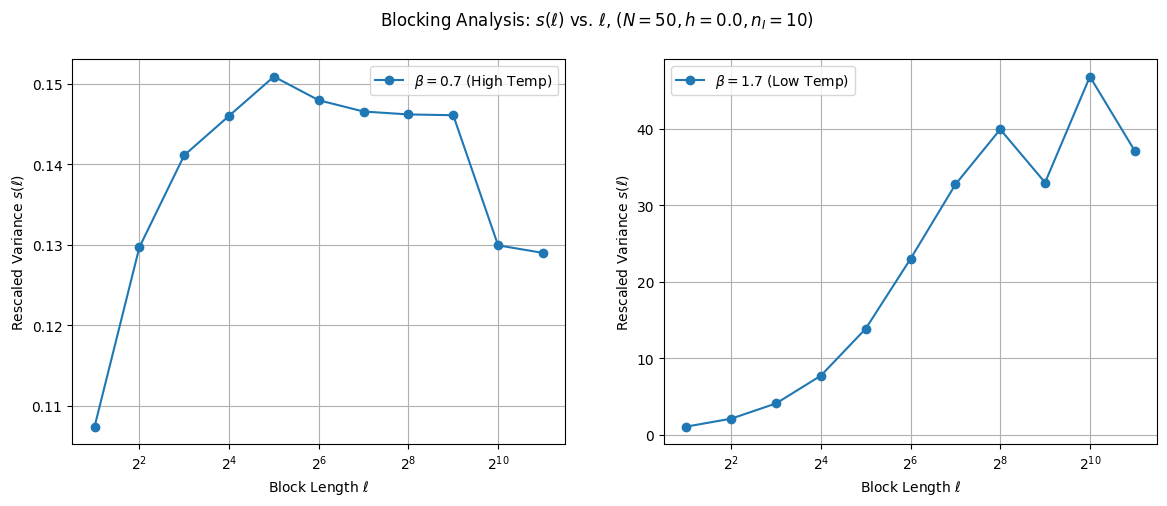

In [49]:
plt.figure(figsize=(14, 5))
plt.suptitle(f'Blocking Analysis: $s(\\ell)$ vs. $\\ell$, ($N={N}, h={h}, n_I={n_I}$)')

plt.subplot(1, 2, 1)
plt.plot(block_sizes, stats_07, 'o-', label=r'$\beta=0.7$ (High Temp)')
plt.xscale('log', base=2)
plt.xlabel(r'Block Length $\ell$')
plt.ylabel(r'Rescaled Variance $s(\ell)$')
plt.legend()
plt.grid(True, which="both")

plt.subplot(1, 2, 2)
plt.plot(block_sizes, stats_17, 'o-', label=r'$\beta=1.7$ (Low Temp)')
plt.xscale('log', base=2)
plt.xlabel(r'Block Length $\ell$')
plt.ylabel(r'Rescaled Variance $s(\ell)$')
plt.legend()
plt.grid(True, which="both")

plt.show()

*   High temperature: The curve starts at a low value and increases rapidly before flattening into a plateau. This is due to the strong thermal fluctuations which are causing the spins to flip frequently, meaning the memory of the system is short. Hence, the correlation time $\tau$ is small. Once the block size $\ell$ exceeds this correlation time, the blocks become statistically independent. Then variance scales as $1/N$, so the rescaled variance becomes constant.

*   Low temperature: Here, the curve starts low but continues to rise for a very long time, barely reaching the plateau. The interaction term $J$ dominates the thermal noise and spins prefer to align with their neighbors, forming large domains that persist for a long time. This means the correlation time is very large. Even for large blocks, the average magnetisation of that block is highly correlated with the next block. This means that the variance does not drop as $1/\ell$ for a long time.

In [72]:
N = 50
J = 1.0
h = 0.0
beta = 2.5  # Low temperature, high correlations
N_I = 5
repeats = 5

K_fixed = 2048
nw_values = [100, 500, 1000, 5000, 10000]
means_nw = []
stds_nw = []

print("Varying n_w (warm-up steps)")
print(f"{'n_w':<6} | {'Mean M':<8} | {'Std':<8}")
print("-" * 30)
for val in nw_values:
    M_values = [run_ising_simulation(N, J, h, beta, val, N_I, K_fixed) for _ in range(repeats)]
    results = np.mean(M_values, axis=0)
    means_nw.append(np.mean(results))
    stds_nw.append(np.std(results))
    print(f"{val:<6} | {np.mean(results):<8.4f} | {np.std(results):<8.4f}")


print("\nVarying K (number of samples)")
print(f"{'K':<6} | {'Mean M':<8} | {'Std':<8}")
print("-" * 30)
nw_fixed = 1000
K_values = [512, 1024, 2048, 4096, 8192]
means_K = []
stds_K = []
for val in K_values:
    M_values = [run_ising_simulation(N, J, h, beta, nw_fixed, N_I, val) for _ in range(repeats)]
    results = np.mean(M_values, axis=0)
    means_K.append(np.mean(results))
    stds_K.append(np.std(results))
    print(f"{val:<6} | {np.mean(results):<8.4f} | {np.std(results):<8.4f}")

Varying n_w (warm-up steps)
n_w    | Mean M   | Std     
------------------------------
100    | 0.8806   | 0.1599  
500    | 0.7032   | 0.1809  
1000   | 0.7183   | 0.1732  
5000   | -0.0162  | 0.1790  
10000  | 0.1686   | 0.3249  

Varying K (number of samples)
K      | Mean M   | Std     
------------------------------
512    | 0.5946   | 0.0186  
1024   | 0.7780   | 0.1913  
2048   | 0.5922   | 0.3408  
4096   | 0.7392   | 0.3272  
8192   | 0.4134   | 0.3554  


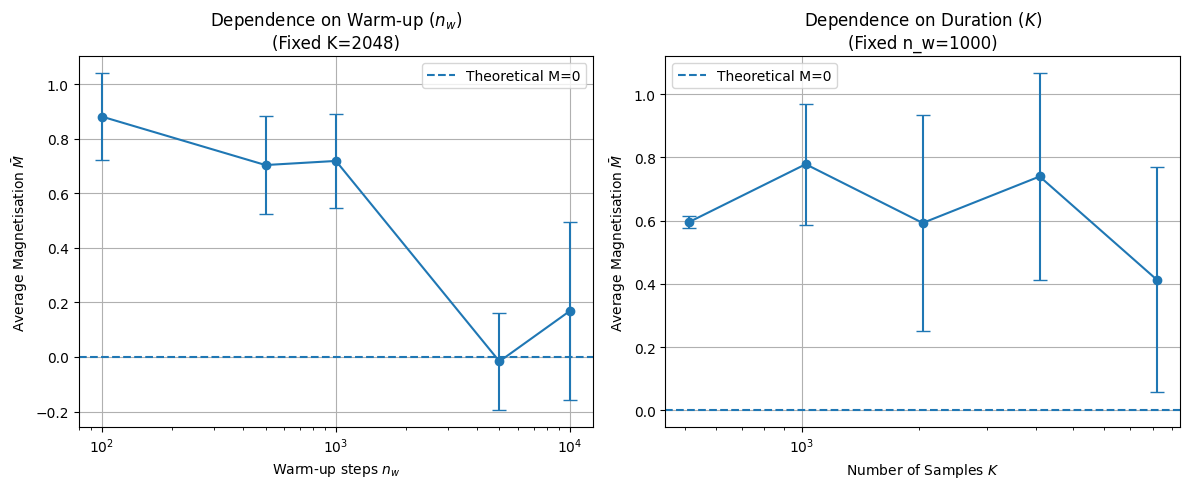

In [73]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

ax1.errorbar(nw_values, means_nw, yerr=stds_nw, fmt='o-', capsize=5)
ax1.axhline(0, linestyle='--', label='Theoretical M=0')
ax1.set_xscale('log')
ax1.set_xlabel(r'Warm-up steps $n_w$')
ax1.set_ylabel(r'Average Magnetisation $\bar{M}$')
ax1.set_title(f'Dependence on Warm-up ($n_w$)\n(Fixed K={K_fixed})')
ax1.legend()
ax1.grid(True)

ax2.errorbar(K_values, means_K, yerr=stds_K, fmt='o-', capsize=5)
ax2.axhline(0, linestyle='--', label='Theoretical M=0')
ax2.set_xscale('log')
ax2.set_xlabel(r'Number of Samples $K$')
ax2.set_ylabel(r'Average Magnetisation $\bar{M}$')
ax2.set_title(f'Dependence on Duration ($K$)\n(Fixed n_w={nw_fixed})')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()

For small $n_w$, the magnetisation $\bar{M}$ is close to $1$ with small error bars. As $n_w$ increases, $\bar{M}$ drops closer to $0$ and the error bars suddenly become large. At low temperatures, the probability of flipping enough spins to reverse the magnetisation is exponentially small $e^{-4J\beta}$. With a small $n_w$, every single simulation remains stuck in the $1$ state so the standard deviation between runs is near zero. The result is precise, but inaccurate, i.e., low variance but high bias.

Increasing $K$ often does not fix the problem. The $\bar{M}$ line is biased away from $0$ regardless of $K$. Statistical error scales as $\sigma /\sqrt{K_{independent}}$. However, the correlation time at high $\beta$ is very long. If the system is trapped in the $1$ valley of the energy landscape, it does not matter how long we measure $K$, as we are only measuring the local valley not the global average. Increasing $K$ only gives us a better estimate of the metastable state magnetisation, not the true equilibrium magnetisation.

At high $\beta$, the variance $s(\ell)$ continued to rise, indicating that the system's memory persists for very long times. Because the system remembers the initial condition (all spins $1$) for a time longer than $n_w + n_IK$, the samples are never truly independent of the starting state. Therefore, the simulation fails to explore the full phase space leading to a biased $\bar{M}$.

In [76]:
def run_ising_history(N, J, h, beta, n_steps):
    '''
    Runs simulation and returns the full history of Magnetisation
    and the final spin configuration.
    '''
    spins = np.ones(N, dtype=int)
    M_history = np.zeros(n_steps)
    current_M = N # sum of spins

    # Precompute probabilities
    neighbor_sums = [-2, 0, 2]
    probs = [1.0 / (1.0 + np.exp(-2.0 * (h + J*s) * beta)) for s in neighbor_sums]

    for t in range(n_steps):
        i = np.random.randint(0, N)
        left = spins[i-1]
        right = spins[(i+1) % N]

        # Neighbor sum index: -2->0, 0->1, 2->2
        n_sum_idx = (left + right + 2) // 2
        prob = probs[n_sum_idx]

        new_spin = 1 if np.random.rand() < prob else -1

        if new_spin != spins[i]:
            current_M += 2 * new_spin
            spins[i] = new_spin

        M_history[t] = current_M / N

    return spins, M_history

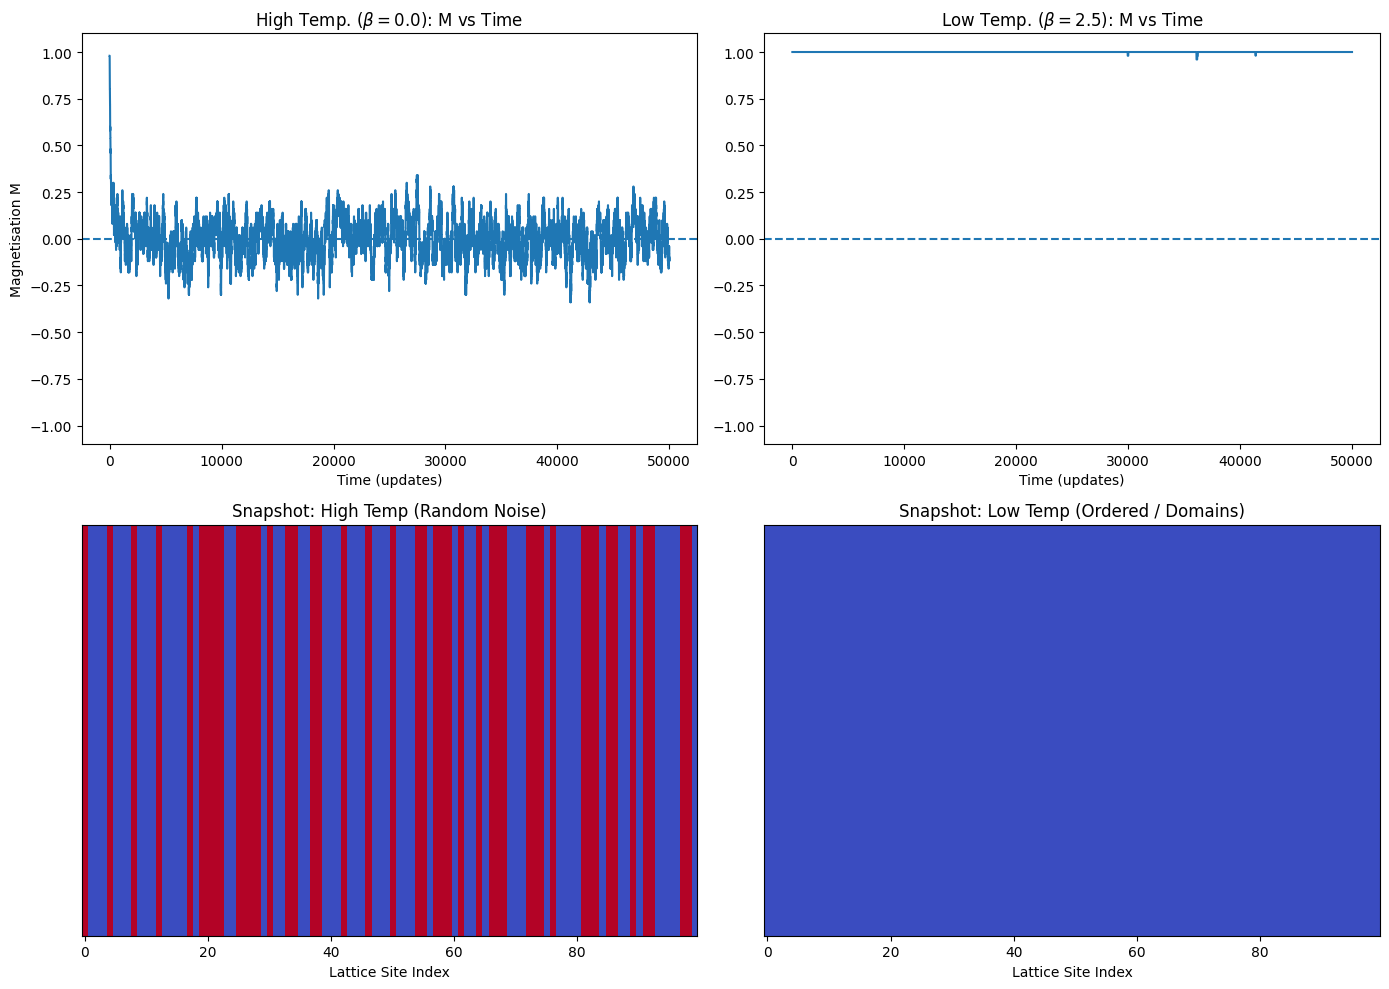

In [85]:
# Parameters
N = 100
J = 1.0
h = 0.0
n_steps = 50000

spins_high, hist_high = run_ising_history(N, J, h, beta=0.0, n_steps=n_steps)
spins_low, hist_low = run_ising_history(N, J, h, beta=2.5, n_steps=n_steps)

fig, axs = plt.subplots(2, 2, figsize=(14, 10))

axs[0, 0].plot(hist_high)
axs[0, 0].set_title(r'High Temp. ($\beta=0.0$): M vs Time')
axs[0, 0].set_ylim(-1.1, 1.1)
axs[0, 0].set_ylabel('Magnetisation M')
axs[0, 0].set_xlabel('Time (updates)')
axs[0, 0].axhline(0, linestyle='--')

axs[0, 1].plot(hist_low)
axs[0, 1].set_title(r'Low Temp. ($\beta=2.5$): M vs Time')
axs[0, 1].set_ylim(-1.1, 1.1)
axs[0, 1].set_xlabel('Time (updates)')
axs[0, 1].axhline(0, linestyle='--')

axs[1, 0].imshow(spins_high.reshape(1, -1), cmap='coolwarm', aspect='auto')
axs[1, 0].set_title('Snapshot: High Temp (Random Noise)')
axs[1, 0].set_yticks([])
axs[1, 0].set_xlabel('Lattice Site Index')

axs[1, 1].imshow(spins_low.reshape(1, -1), cmap='coolwarm', aspect='auto')
axs[1, 1].set_title('Snapshot: Low Temp (Ordered / Domains)')
axs[1, 1].set_yticks([])
axs[1, 1].set_xlabel('Lattice Site Index')

plt.tight_layout()
plt.show()

The behavior of the Ising model is a competition between energy (which wants order) and entropy (which wants disorder).

*   High temperature, $T \gg J$ and $\beta \approx 0$:
    *   Thermal energy dominates. The probability cost of aligning against neighbors is low. Thus, entropy wins.
    *   Spins are randomly oriented. The state of a spin has almost no influence on distant neighbors. The correlation length is very short.
    *   The average $M$ fluctuates rapidly around $0$ after an initial warm-up period.

*   Low temperature, $T \ll J$ and $\beta \gg 0$:
    *   Interaction energy dominates. Spins strongly prefer to align with neighbors to minimise energy.
    *   The system forms large domains of identical spins. In the extreme case, the whole system aligns. The correlation length becomes very large.
    *   We see that the system tends to get stuck in a highly magnetized state for long periods.

The behavior depends on the ratio between the system size $N$ and the correlation length $\xi$.

*   If $N \gg \xi$ (large system or high temperature), then the system contains many independent domains. The random $1$ and $-1$ domains cancel out, so $\bar{M} \approx 0$. Increasing $N$ further simply reduces the statistical noise since variance drops as $1/N$.
*   If $N \ll \xi$ (small system or low temperature), then the correlation length exceeds the system size. The entire system acts as a single spin of entirely $1$ or $-1$. To flip from one to the other requires creating a domain wall, which has energy cost $2J$, and moving it across the entire circle.

As a result, we have some computational consequences.

*   At high $T$, the system relaxes quickly. Any initial condition is forgotten in a few sweeps. We can obtain accurate estimates with small $n_w$ and small $K$.
*   At low $T$, to change the global magnetisation, a domain wall must be created and diffuse across the entire lattice via a random walk. This is a very slow process. Consequently, the simulation becomes non-ergodic on practical timescales.